In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

In [2]:
#load data/AllWeathDTypes_NWPP_10yrs.csv as a dataframe
dfX = pd.read_csv("data/AllWeathDTypes_NWPP_10yrs.csv")
dfY = pd.read_csv("data/RTLoad_MIDC+NW_10yrs.csv")
#subtract 7 hours from datetime to convert from UTC to PST
dfY['datetime'] = pd.to_datetime(dfY['datetime'])
dfY['datetime'] = dfY['datetime'] - pd.Timedelta(hours=7)
dfX['datetime'] = pd.to_datetime(dfX['datetime'])
dfX['datetime'] = (dfX['datetime'] - pd.Timedelta(hours=7))

In [3]:
#data cleaning. TODO : construct a py file for this
#drop rows with temperature less than 0
dfX = dfX[dfX['temperature'] >= 0]

In [5]:
from helpers import totalload

# Use the totalload function to calculate the total load
start_date = '2022-03-01'
end_date = '2025-06-01'
dfY = totalload(dfY, start_date, end_date)

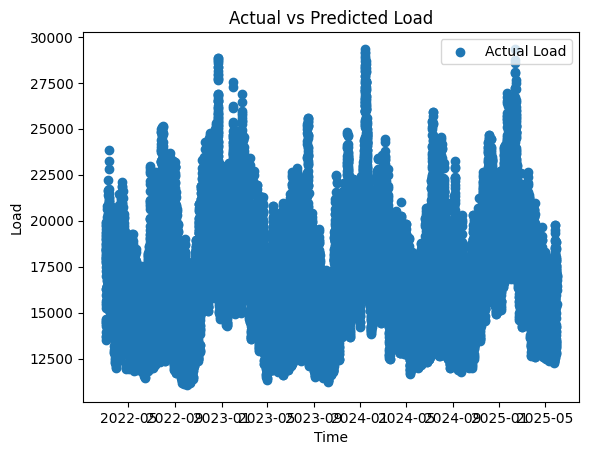

In [6]:
#plot the total load
plt.figure()
plt.scatter(dfY.index, dfY['Total Load'], label='Actual Load')
plt.title('Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

In [7]:
# Extract date and time components from the 'datetime' column
dfX['year'] = dfX['datetime'].dt.year
dfX['month'] = dfX['datetime'].dt.month
dfX['date'] = dfX['datetime'].dt.day
dfX['day'] = dfX['datetime'].dt.dayofweek
dfX['time'] = dfX['datetime'].dt.hour
dfX['temperature_spread'] = dfX['temperature_max'] - dfX['temperature_min']

In [8]:
df_XY = pd.merge(dfX, dfY, on='datetime')
df_XY.head()

,datetime,cloudCover,dewpoint,electric_cdd,electric_hdd,gas_cdd,gas_hdd,heatIndex,population_cdd,population_hdd,...,windChill,windDirection,windSpeed,year,month,date,day,time,temperature_spread,Total Load
0,2022-03-02 00:00:00,77.0,42.0,NaN,NaN,NaN,NaN,49.0,NaN,NaN,...,46.0,129.0,6.0,2022,3,2,2,0,NaN,15502.000000
1,2022-03-02 01:00:00,76.0,42.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,44.0,127.0,6.0,2022,3,2,2,1,NaN,14518.250000
2,2022-03-02 02:00:00,81.0,42.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,44.0,121.0,5.0,2022,3,2,2,2,NaN,13943.250000
3,2022-03-02 03:00:00,86.0,43.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,44.0,104.0,6.0,2022,3,2,2,3,NaN,13651.666667
4,2022-03-02 04:00:00,85.0,42.0,NaN,NaN,NaN,NaN,46.0,NaN,NaN,...,45.0,144.0,3.0,2022,3,2,2,4,NaN,13507.416667


In [9]:
#print latest datetime in df_XY
print("Latest datetime in df_XY:", df_XY['datetime'].max())

Latest datetime in df_XY: 2025-05-31 23:00:00


In [10]:
#groupby date and get mean of each day
# df_daily = df_XY.groupby(df_XY['datetime'].dt.date).mean()

In [11]:
df_XY.head()

,datetime,cloudCover,dewpoint,electric_cdd,electric_hdd,gas_cdd,gas_hdd,heatIndex,population_cdd,population_hdd,...,windChill,windDirection,windSpeed,year,month,date,day,time,temperature_spread,Total Load
0,2022-03-02 00:00:00,77.0,42.0,NaN,NaN,NaN,NaN,49.0,NaN,NaN,...,46.0,129.0,6.0,2022,3,2,2,0,NaN,15502.000000
1,2022-03-02 01:00:00,76.0,42.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,44.0,127.0,6.0,2022,3,2,2,1,NaN,14518.250000
2,2022-03-02 02:00:00,81.0,42.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,44.0,121.0,5.0,2022,3,2,2,2,NaN,13943.250000
3,2022-03-02 03:00:00,86.0,43.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,44.0,104.0,6.0,2022,3,2,2,3,NaN,13651.666667
4,2022-03-02 04:00:00,85.0,42.0,NaN,NaN,NaN,NaN,46.0,NaN,NaN,...,45.0,144.0,3.0,2022,3,2,2,4,NaN,13507.416667



R-squared on training data: 0.9648
R-squared on test data: 0.9566


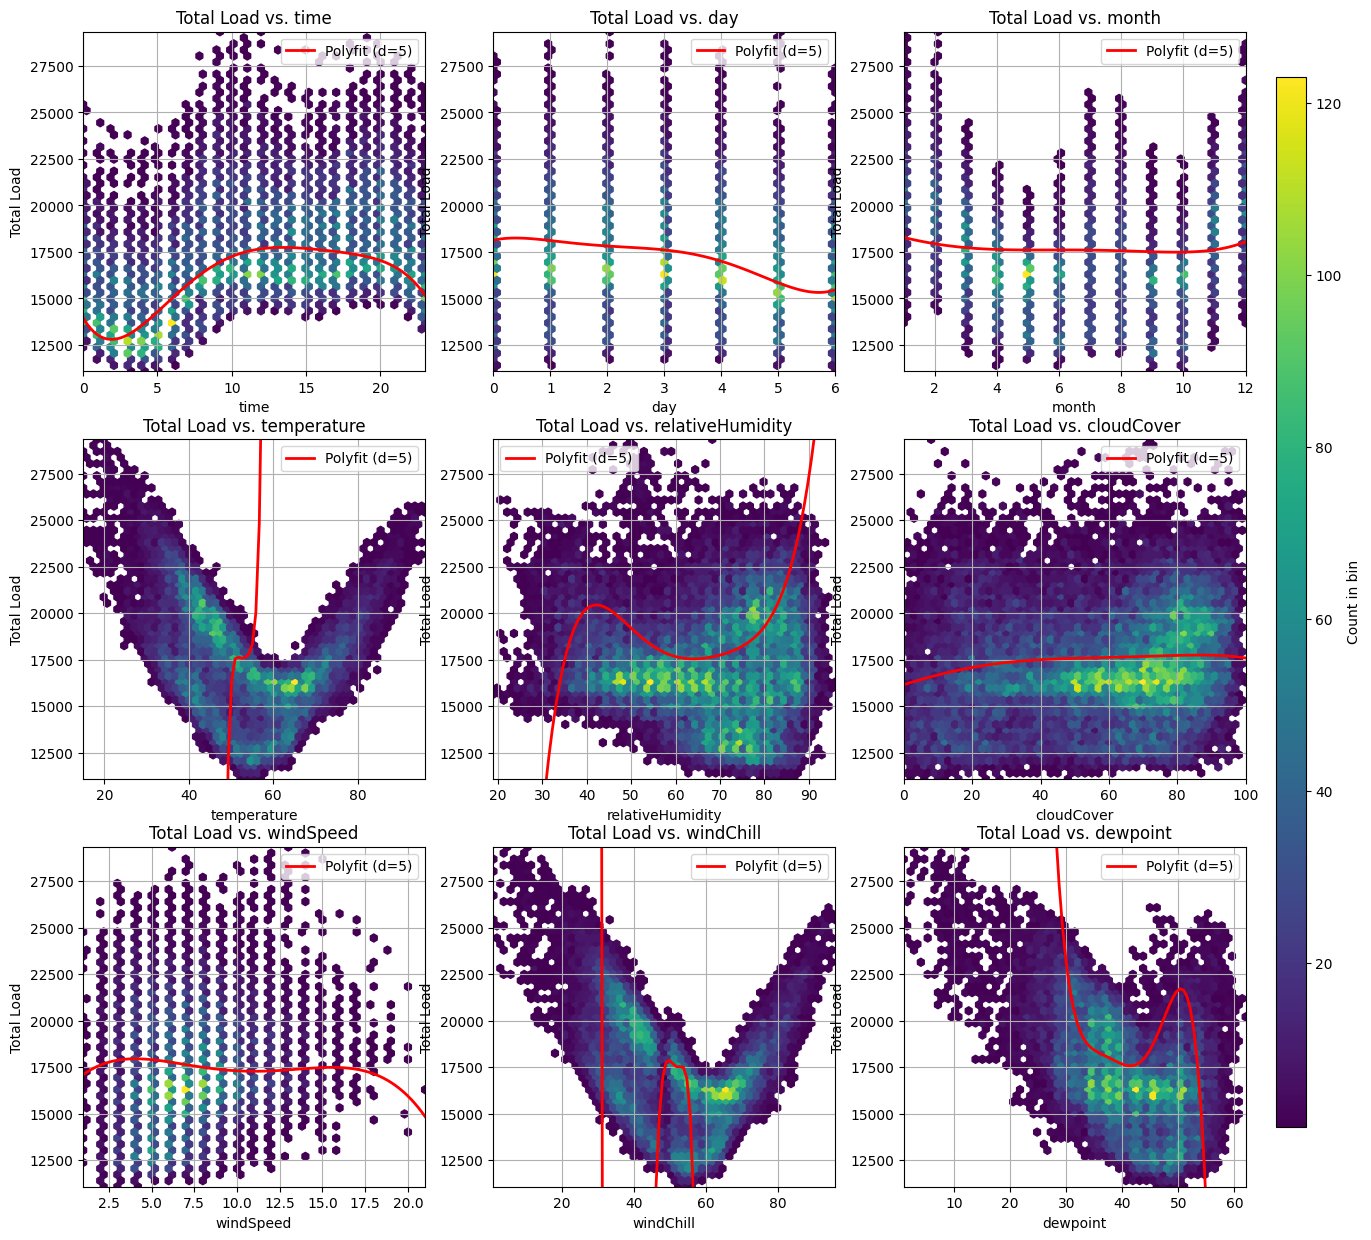

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# 1. Feature Engineering and Selection
features = ['time', 'day', 'month', 'temperature', 'relativeHumidity', 'cloudCover','windSpeed','windChill','dewpoint']
target = 'Total Load'

X = df_XY[features]
y = df_XY[target]

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Polynomial Regression
poly_degree = 5
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the model
model = LinearRegression()
model.fit(X_train_poly, y_train)


train_r2 = model.score(X_train_poly, y_train)
test_r2 = model.score(X_test_poly, y_test)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")

# 6. Visualization
# Create a figure with subplots for each feature
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# To plot the effect of each feature, we hold other features at their mean
X_train_scaled_mean = X_train_scaled.mean(axis=0)

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Generate a range of values for the current feature
    feature_col_index = X_train.columns.get_loc(feature)
    feature_range_scaled = np.linspace(X_train_scaled[:, feature_col_index].min(), X_train_scaled[:, feature_col_index].max(), 100)
    
    # Create a test set where only the current feature varies
    plot_X_scaled = np.tile(X_train_scaled_mean, (100, 1))
    plot_X_scaled[:, feature_col_index] = feature_range_scaled
    
    # Transform for polynomial prediction
    plot_X_poly = poly.transform(plot_X_scaled)
    
    # Predict
    y_pred_plot = model.predict(plot_X_poly)
    
    # Inverse transform the feature values to their original scale for plotting
    feature_range_original = scaler.inverse_transform(plot_X_scaled)[:, feature_col_index]
    
    # Sort values for a smooth line plot
    sort_indices = np.argsort(feature_range_original)
    
    # Density plot (hexbin) of original data
    hb = ax.hexbin(X_train[feature], y_train, gridsize=50, cmap='viridis', mincnt=1)
    
    # Plot the polynomial curve
    ax.plot(feature_range_original[sort_indices], y_pred_plot[sort_indices], color='red', linewidth=2, label=f'Polyfit (d={poly_degree})')
    
    # Set x and y limits based on the data range
    ax.set_xlim(X_train[feature].min(), X_train[feature].max())
    ax.set_ylim(y_train.min(), y_train.max())
    
    ax.set_xlabel(feature)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs. {feature}')
    ax.legend()
    ax.grid(True)

# Add a common colorbar for all hexbin plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='Count in bin')

# Hide any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


R-squared on training data: 0.9589
R-squared on test data: 0.9558


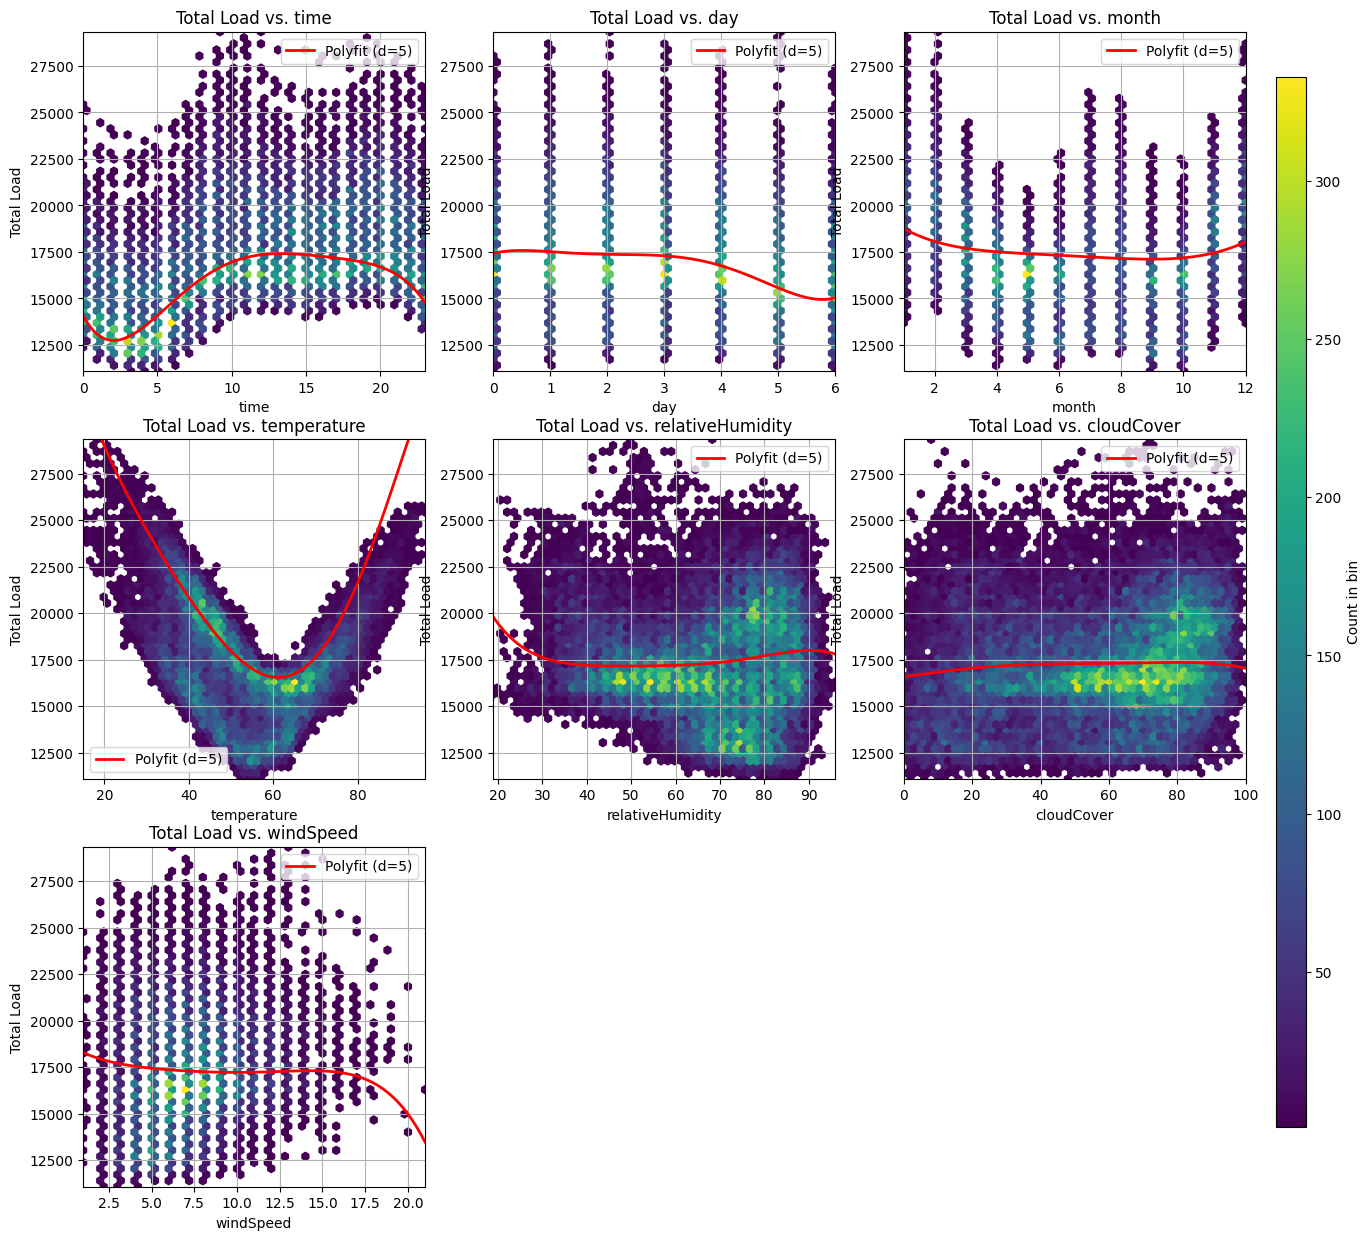

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# 1. Feature Engineering and Selection
features = ['time', 'day', 'month', 'temperature', 'relativeHumidity', 'cloudCover','windSpeed']
target = 'Total Load'

X = df_XY[features]
y = df_XY[target]

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Polynomial Regression
poly_degree = 5
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the model
model = LinearRegression()
model.fit(X_train_poly, y_train)


train_r2 = model.score(X_train_poly, y_train)
test_r2 = model.score(X_test_poly, y_test)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")

# 6. Visualization
# Create a figure with subplots for each feature
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# To plot the effect of each feature, we hold other features at their mean
X_train_scaled_mean = X_train_scaled.mean(axis=0)

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Generate a range of values for the current feature
    feature_col_index = X_train.columns.get_loc(feature)
    feature_range_scaled = np.linspace(X_train_scaled[:, feature_col_index].min(), X_train_scaled[:, feature_col_index].max(), 100)
    
    # Create a test set where only the current feature varies
    plot_X_scaled = np.tile(X_train_scaled_mean, (100, 1))
    plot_X_scaled[:, feature_col_index] = feature_range_scaled
    
    # Transform for polynomial prediction
    plot_X_poly = poly.transform(plot_X_scaled)
    
    # Predict
    y_pred_plot = model.predict(plot_X_poly)
    
    # Inverse transform the feature values to their original scale for plotting
    feature_range_original = scaler.inverse_transform(plot_X_scaled)[:, feature_col_index]
    
    # Sort values for a smooth line plot
    sort_indices = np.argsort(feature_range_original)
    
    # Density plot (hexbin) of original data
    hb = ax.hexbin(X_train[feature], y_train, gridsize=50, cmap='viridis', mincnt=1)
    
    # Plot the polynomial curve
    ax.plot(feature_range_original[sort_indices], y_pred_plot[sort_indices], color='red', linewidth=2, label=f'Polyfit (d={poly_degree})')
    
    # Set x and y limits based on the data range
    ax.set_xlim(X_train[feature].min(), X_train[feature].max())
    ax.set_ylim(y_train.min(), y_train.max())
    
    ax.set_xlabel(feature)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs. {feature}')
    ax.legend()
    ax.grid(True)

# Add a common colorbar for all hexbin plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='Count in bin')

# Hide any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


R-squared on training data: 0.9424
R-squared on test data: 0.9419


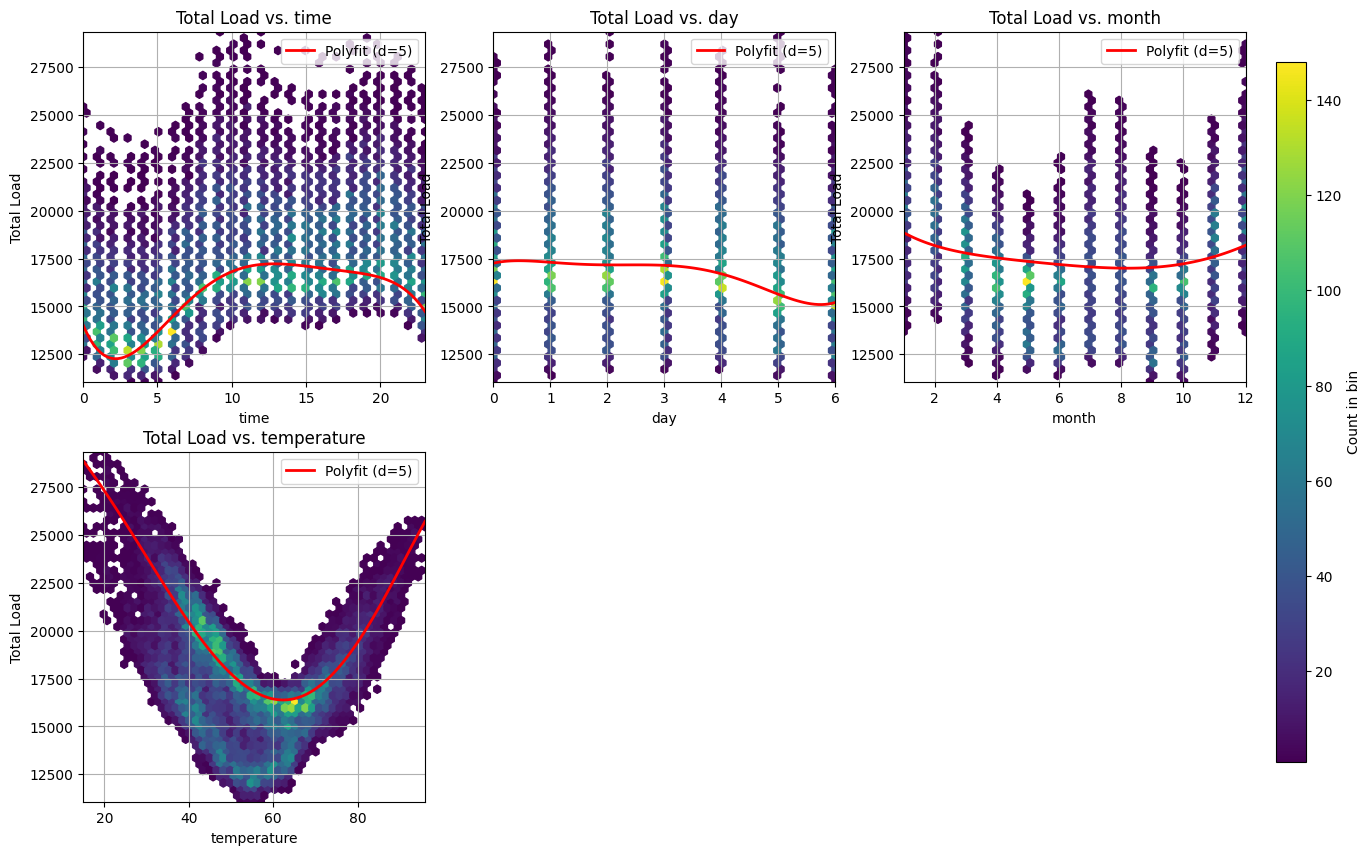

In [14]:
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# 1. Feature Engineering and Selection
features = ['time', 'day', 'month', 'temperature']
target = 'Total Load'

X = df_XY[features]
y = df_XY[target]

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Polynomial Regression
poly_degree = 5
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the model
model = LinearRegression()
model.fit(X_train_poly, y_train)


train_r2 = model.score(X_train_poly, y_train)
test_r2 = model.score(X_test_poly, y_test)

print(f"\nR-squared on training data: {train_r2:.4f}")
print(f"R-squared on test data: {test_r2:.4f}")

# 6. Visualization
# Create a figure with subplots for each feature
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# To plot the effect of each feature, we hold other features at their mean
X_train_scaled_mean = X_train_scaled.mean(axis=0)

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Generate a range of values for the current feature
    feature_col_index = X_train.columns.get_loc(feature)
    feature_range_scaled = np.linspace(X_train_scaled[:, feature_col_index].min(), X_train_scaled[:, feature_col_index].max(), 100)
    
    # Create a test set where only the current feature varies
    plot_X_scaled = np.tile(X_train_scaled_mean, (100, 1))
    plot_X_scaled[:, feature_col_index] = feature_range_scaled
    
    # Transform for polynomial prediction
    plot_X_poly = poly.transform(plot_X_scaled)
    
    # Predict
    y_pred_plot = model.predict(plot_X_poly)
    
    # Inverse transform the feature values to their original scale for plotting
    feature_range_original = scaler.inverse_transform(plot_X_scaled)[:, feature_col_index]
    
    # Sort values for a smooth line plot
    sort_indices = np.argsort(feature_range_original)
    
    # Density plot (hexbin) of original data
    hb = ax.hexbin(X_train[feature], y_train, gridsize=50, cmap='viridis', mincnt=1)
    
    # Plot the polynomial curve
    ax.plot(feature_range_original[sort_indices], y_pred_plot[sort_indices], color='red', linewidth=2, label=f'Polyfit (d={poly_degree})')
    
    # Set x and y limits based on the data range
    ax.set_xlim(X_train[feature].min(), X_train[feature].max())
    ax.set_ylim(y_train.min(), y_train.max())
    
    ax.set_xlabel(feature)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs. {feature}')
    ax.legend()
    ax.grid(True)

# Add a common colorbar for all hexbin plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='Count in bin')

# Hide any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()

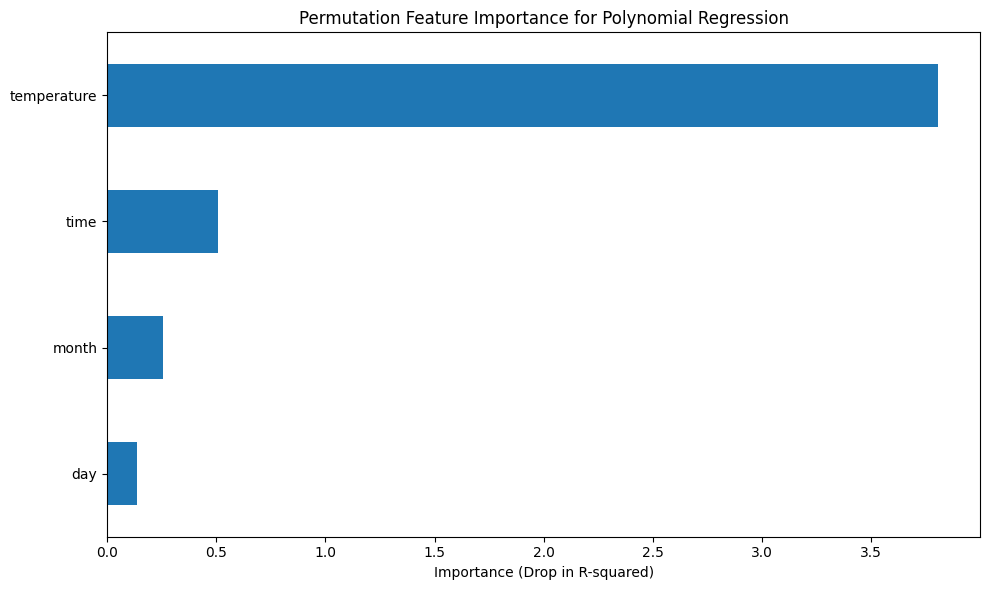

Feature Importances (summed from polynomial terms):
temperature    3.808339
time           0.506633
month          0.253503
day            0.137302
dtype: float64


In [15]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on the test set
# We use the test set to see how important features are for making predictions on unseen data.
# The polynomial features (X_test_poly) and corresponding target values (y_test) are used.
result = permutation_importance(
    model, X_test_poly, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# The result gives importance for each polynomial feature. We need to map this back to the original features.
# We can do this by summing the importances of all polynomial terms that include a given original feature.
original_feature_importance = np.zeros(len(features))
poly_feature_names = poly.get_feature_names_out(features)

for i, feature in enumerate(features):
    # Find all polynomial features that contain the original feature
    indices = [j for j, name in enumerate(poly_feature_names) if feature in name.split()]
    # Sum the importances of these polynomial features
    original_feature_importance[i] = result.importances_mean[indices].sum()

# Create a pandas Series for easier plotting and viewing
importance_df = pd.Series(original_feature_importance, index=features)

# Sort the features by importance
sorted_importance = importance_df.sort_values(ascending=True)

# Plotting the feature importances
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importance.plot(kind='barh', ax=ax)
ax.set_title('Permutation Feature Importance for Polynomial Regression')
ax.set_xlabel('Importance (Drop in R-squared)')
plt.tight_layout()
plt.show()

print("Feature Importances (summed from polynomial terms):")
print(sorted_importance.sort_values(ascending=False))

In [16]:
# Predict on the test data
y_pred_test = model.predict(X_test_poly)

# Create a new dataframe with the test data, actual load, and predicted load
df_results = X_test.copy()
df_results['Actual Load'] = y_test
df_results['Predicted Load'] = y_pred_test

# Display the first few rows of the results dataframe
df_results.head(30)

,time,day,month,temperature,Actual Load,Predicted Load
4596,12,4,9,72.0,16461.583333,16453.216883
25405,13,3,1,39.0,22990.333333,22413.359203
8957,5,4,3,40.0,16751.666667,16682.167754
8870,14,0,3,45.0,19808.750000,20302.751225
96,0,6,3,39.0,16791.666667,18324.767564
16586,2,0,1,42.0,16656.666667,14831.449488
24529,1,2,12,47.0,17013.750000,15311.719629
12524,20,5,8,74.0,17485.416667,17751.877123
3473,17,6,7,85.0,20215.333333,20130.165026
15505,1,4,12,39.0,17339.000000,17476.229274


In [17]:
df_results.info(), X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2849 entries, 4596 to 18879
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            2849 non-null   int32  
 1   day             2849 non-null   int32  
 2   month           2849 non-null   int32  
 3   temperature     2849 non-null   float64
 4   Actual Load     2849 non-null   float64
 5   Predicted Load  2849 non-null   float64
dtypes: float64(3), int32(3)
memory usage: 122.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28487 entries, 0 to 28486
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         28487 non-null  int32  
 1   day          28487 non-null  int32  
 2   month        28487 non-null  int32  
 3   temperature  28487 non-null  float64
dtypes: float64(1), int32(3)
memory usage: 556.5 KB


(None, None)

In [18]:
#find average load and the mean absolute error
df_results['Absolute Error'] = np.abs(df_results['Actual Load'] - df_results['Predicted Load'])
average_load = df_results['Actual Load'].mean()
mean_absolute_error = df_results['Absolute Error'].mean()
error_percentage = (mean_absolute_error / average_load) * 100

print("Average Load:", average_load)
print("Mean Absolute Error:", mean_absolute_error)
print("Error Percentage:", error_percentage)

Average Load: 17163.780221509653
Mean Absolute Error: 545.5013408694425
Error Percentage: 3.1782121061292785


In [19]:
#print standard deviation of the error in train and test set
print("Standard Deviation of Absolute Error:", df_results['Absolute Error'].std())
std_error_percentage = (df_results['Absolute Error'].std() / average_load) * 100
print("Standard Deviation of Absolute Error (% of Average Load):", std_error_percentage)

Standard Deviation of Absolute Error: 440.63625276629654
Standard Deviation of Absolute Error (% of Average Load): 2.5672447857033913
